In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from Utils.DataLoader import DataLoader
from Utils.DataTransformer import DataTransformer
from Utils.DuckDb.DuckDb import DuckDb
from Utils.DatasetProcessor.DatasetProcessorUtils import DatasetProcessorUtils
from datetime import datetime
import pandas as pd
from typing import List
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from Utils import PandasNotebookConfigs
import project_config

# Importing all the tools we need

# Regular EDA (Exploratory Data Analysis) and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# If matplotlib plots don't work, uncomment this line
# %matplotlib inline

# Models from Scikit-Learn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Model evaluations
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, RocCurveDisplay

# Models from Scikit-Learn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Model evaluations
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, RocCurveDisplay
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

/home/caio/Git-Projetos/2025-case-data-master-caio-arrabal/env/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 9.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [3]:
PandasNotebookConfigs.config()

Ajustando display.float.format para %.4f
Ajustando prints de linhas e colunas


In [4]:
DUCK_DB_UTILS = DuckDb()
DATA_TRANSFORMER = DataTransformer()
DATA_PROCESSOR_UTILS = DatasetProcessorUtils(DUCK_DB_UTILS)

In [5]:
TABLE_NAME = project_config.PRE_PREPARED_DATA_TABLE

In [6]:
df = DUCK_DB_UTILS.load_table(
    TABLE_NAME,
    limit = 200_000,
    where_condition=f'WHERE safra <= {project_config.TEST_DATA_UNTIL_SAFRA}' # We'll split train data and validation data later
)

In [7]:
len(df)

200000

In [8]:
# Shuffle
# df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [9]:
df.head()

,cost,msno,safra,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,total_hours,msno_1,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,is_cancel,safra_1,transaction_date_year,transaction_date_month,transaction_date_day,transaction_date_day_of_week,transaction_date_day_of_year,membership_expire_date_year,membership_expire_date_month,membership_expire_date_day,membership_expire_date_day_of_week,membership_expire_date_day_of_year,discount,price_per_month,members_msno,members_safra,city,registered_via,is_active,registration_init_time_year,registration_init_time_month,registration_init_time_day,registration_init_time_day_of_week,registration_init_time_day_of_year,_filled_out_members_info,is_churn,no_churn_information,num_unq-2M,num_unq-1M,total_secs-2M,total_secs-1M,num_25-2M,num_25-1M,num_50-2M,num_50-1M,num_75-2M,num_75-1M,num_985-2M,num_985-1M,num_100-2M,num_100-1M
0,55.9125,+++FOrTS7ab3tIgIh8eWwX4FqRv8w/FoiOuyXsFvphY=,201609,60,12,14,7,171,179,49996,13.8878,+++FOrTS7ab3tIgIh8eWwX4FqRv8w/FoiOuyXsFvphY=,35,7,0,0,False,False,201609,2016,9,9,4,253,2016,9,14,2,258,0,0.0000,+++FOrTS7ab3tIgIh8eWwX4FqRv8w/FoiOuyXsFvphY=,201609,15,9,True,2004,3,27,5,87,Infos já existentes,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,67.3556,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,201611,128,71,50,101,470,488,148668,41.2967,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,41,30,99,99,True,False,201611,2016,11,16,2,321,2016,12,15,3,350,0,99.0000,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,201611,1,7,True,2014,6,8,6,159,Infos já existentes,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,52.9465,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,201501,58,8,4,2,82,137,22478,6.2439,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,39,31,149,149,True,False,201501,2015,1,31,5,31,2015,3,19,3,78,0,144.1935,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,<NA>,15,9,True,2010,11,18,3,322,Copiadas,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,55.5166,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,201502,27,5,4,3,203,136,48230,13.3972,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,39,31,149,149,True,False,201502,2015,2,28,5,59,2015,4,19,6,109,0,144.1935,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,<NA>,15,9,True,2010,11,18,3,322,Copiadas,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,52.6188,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,201503,37,15,6,8,73,94,21394,5.9428,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,39,31,149,149,True,False,201503,2015,3,31,1,90,2015,5,19,1,139,0,144.1935,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,<NA>,15,9,True,2010,11,18,3,322,Copiadas,False,False,137.0000,136.0000,22478.0000,48230.0000,58.0000,27.0000,8.0000,5.0000,4.0000,4.0000,2.0000,3.0000,82.0000,203.0000


In [10]:
df = DATA_PROCESSOR_UTILS.calc_remaining_days(df)

In [11]:
df.head()

,cost,msno,safra,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,total_hours,msno_1,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,is_cancel,safra_1,transaction_date_year,transaction_date_month,transaction_date_day,transaction_date_day_of_week,transaction_date_day_of_year,membership_expire_date_year,membership_expire_date_month,membership_expire_date_day,membership_expire_date_day_of_week,membership_expire_date_day_of_year,discount,price_per_month,members_msno,members_safra,city,registered_via,is_active,registration_init_time_year,registration_init_time_month,registration_init_time_day,registration_init_time_day_of_week,registration_init_time_day_of_year,_filled_out_members_info,is_churn,no_churn_information,num_unq-2M,num_unq-1M,total_secs-2M,total_secs-1M,num_25-2M,num_25-1M,num_50-2M,num_50-1M,num_75-2M,num_75-1M,num_985-2M,num_985-1M,num_100-2M,num_100-1M,remaining_days
0,55.9125,+++FOrTS7ab3tIgIh8eWwX4FqRv8w/FoiOuyXsFvphY=,201609,60,12,14,7,171,179,49996,13.8878,+++FOrTS7ab3tIgIh8eWwX4FqRv8w/FoiOuyXsFvphY=,35,7,0,0,False,False,201609,2016,9,9,4,253,2016,9,14,2,258,0,0.0000,+++FOrTS7ab3tIgIh8eWwX4FqRv8w/FoiOuyXsFvphY=,201609,15,9,True,2004,3,27,5,87,Infos já existentes,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0000
1,67.3556,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,201611,128,71,50,101,470,488,148668,41.2967,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,41,30,99,99,True,False,201611,2016,11,16,2,321,2016,12,15,3,350,0,99.0000,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,201611,1,7,True,2014,6,8,6,159,Infos já existentes,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.0000
2,52.9465,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,201501,58,8,4,2,82,137,22478,6.2439,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,39,31,149,149,True,False,201501,2015,1,31,5,31,2015,3,19,3,78,0,144.1935,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,<NA>,15,9,True,2010,11,18,3,322,Copiadas,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.0000
3,55.5166,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,201502,27,5,4,3,203,136,48230,13.3972,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,39,31,149,149,True,False,201502,2015,2,28,5,59,2015,4,19,6,109,0,144.1935,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,<NA>,15,9,True,2010,11,18,3,322,Copiadas,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0000
4,52.6188,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,201503,37,15,6,8,73,94,21394,5.9428,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,39,31,149,149,True,False,201503,2015,3,31,1,90,2015,5,19,1,139,0,144.1935,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,<NA>,15,9,True,2010,11,18,3,322,Copiadas,False,False,137.0000,136.0000,22478.0000,48230.0000,58.0000,27.0000,8.0000,5.0000,4.0000,4.0000,2.0000,3.0000,82.0000,203.0000,49.0000


In [12]:
# Treating DF
df.isna().sum().T

cost                                      0
msno                                      0
safra                                     0
num_25                                    0
num_50                                    0
num_75                                    0
num_985                                   0
num_100                                   0
num_unq                                   0
total_secs                                0
total_hours                               0
msno_1                                    0
payment_method_id                         0
payment_plan_days                         0
plan_list_price                           0
actual_amount_paid                        0
is_auto_renew                             0
is_cancel                                 0
safra_1                                   0
transaction_date_year                     0
transaction_date_month                    0
transaction_date_day                      0
transaction_date_day_of_week    

In [13]:
df.head()

,cost,msno,safra,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,total_hours,msno_1,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,is_cancel,safra_1,transaction_date_year,transaction_date_month,transaction_date_day,transaction_date_day_of_week,transaction_date_day_of_year,membership_expire_date_year,membership_expire_date_month,membership_expire_date_day,membership_expire_date_day_of_week,membership_expire_date_day_of_year,discount,price_per_month,members_msno,members_safra,city,registered_via,is_active,registration_init_time_year,registration_init_time_month,registration_init_time_day,registration_init_time_day_of_week,registration_init_time_day_of_year,_filled_out_members_info,is_churn,no_churn_information,num_unq-2M,num_unq-1M,total_secs-2M,total_secs-1M,num_25-2M,num_25-1M,num_50-2M,num_50-1M,num_75-2M,num_75-1M,num_985-2M,num_985-1M,num_100-2M,num_100-1M,remaining_days
0,55.9125,+++FOrTS7ab3tIgIh8eWwX4FqRv8w/FoiOuyXsFvphY=,201609,60,12,14,7,171,179,49996,13.8878,+++FOrTS7ab3tIgIh8eWwX4FqRv8w/FoiOuyXsFvphY=,35,7,0,0,False,False,201609,2016,9,9,4,253,2016,9,14,2,258,0,0.0000,+++FOrTS7ab3tIgIh8eWwX4FqRv8w/FoiOuyXsFvphY=,201609,15,9,True,2004,3,27,5,87,Infos já existentes,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0000
1,67.3556,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,201611,128,71,50,101,470,488,148668,41.2967,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,41,30,99,99,True,False,201611,2016,11,16,2,321,2016,12,15,3,350,0,99.0000,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,201611,1,7,True,2014,6,8,6,159,Infos já existentes,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.0000
2,52.9465,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,201501,58,8,4,2,82,137,22478,6.2439,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,39,31,149,149,True,False,201501,2015,1,31,5,31,2015,3,19,3,78,0,144.1935,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,<NA>,15,9,True,2010,11,18,3,322,Copiadas,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.0000
3,55.5166,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,201502,27,5,4,3,203,136,48230,13.3972,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,39,31,149,149,True,False,201502,2015,2,28,5,59,2015,4,19,6,109,0,144.1935,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,<NA>,15,9,True,2010,11,18,3,322,Copiadas,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0000
4,52.6188,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,201503,37,15,6,8,73,94,21394,5.9428,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,39,31,149,149,True,False,201503,2015,3,31,1,90,2015,5,19,1,139,0,144.1935,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,<NA>,15,9,True,2010,11,18,3,322,Copiadas,False,False,137.0000,136.0000,22478.0000,48230.0000,58.0000,27.0000,8.0000,5.0000,4.0000,4.0000,2.0000,3.0000,82.0000,203.0000,49.0000


In [14]:
# Feature engineering
df = DATA_PROCESSOR_UTILS.split_safras(df, drop_safra=False)

In [15]:
df.head()

,cost,msno,safra,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,total_hours,msno_1,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,is_cancel,safra_1,transaction_date_year,transaction_date_month,transaction_date_day,transaction_date_day_of_week,transaction_date_day_of_year,membership_expire_date_year,membership_expire_date_month,membership_expire_date_day,membership_expire_date_day_of_week,membership_expire_date_day_of_year,discount,price_per_month,members_msno,members_safra,city,registered_via,is_active,registration_init_time_year,registration_init_time_month,registration_init_time_day,registration_init_time_day_of_week,registration_init_time_day_of_year,_filled_out_members_info,is_churn,no_churn_information,num_unq-2M,num_unq-1M,total_secs-2M,total_secs-1M,num_25-2M,num_25-1M,num_50-2M,num_50-1M,num_75-2M,num_75-1M,num_985-2M,num_985-1M,num_100-2M,num_100-1M,remaining_days,safra_year,safra_month
0,55.9125,+++FOrTS7ab3tIgIh8eWwX4FqRv8w/FoiOuyXsFvphY=,201609,60,12,14,7,171,179,49996,13.8878,+++FOrTS7ab3tIgIh8eWwX4FqRv8w/FoiOuyXsFvphY=,35,7,0,0,False,False,201609,2016,9,9,4,253,2016,9,14,2,258,0,0.0000,+++FOrTS7ab3tIgIh8eWwX4FqRv8w/FoiOuyXsFvphY=,201609,15,9,True,2004,3,27,5,87,Infos já existentes,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0000,2016.0000,9.0000
1,67.3556,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,201611,128,71,50,101,470,488,148668,41.2967,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,41,30,99,99,True,False,201611,2016,11,16,2,321,2016,12,15,3,350,0,99.0000,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,201611,1,7,True,2014,6,8,6,159,Infos já existentes,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.0000,2016.0000,11.0000
2,52.9465,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,201501,58,8,4,2,82,137,22478,6.2439,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,39,31,149,149,True,False,201501,2015,1,31,5,31,2015,3,19,3,78,0,144.1935,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,<NA>,15,9,True,2010,11,18,3,322,Copiadas,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.0000,2015.0000,1.0000
3,55.5166,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,201502,27,5,4,3,203,136,48230,13.3972,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,39,31,149,149,True,False,201502,2015,2,28,5,59,2015,4,19,6,109,0,144.1935,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,<NA>,15,9,True,2010,11,18,3,322,Copiadas,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0000,2015.0000,2.0000
4,52.6188,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,201503,37,15,6,8,73,94,21394,5.9428,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,39,31,149,149,True,False,201503,2015,3,31,1,90,2015,5,19,1,139,0,144.1935,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,<NA>,15,9,True,2010,11,18,3,322,Copiadas,False,False,137.0000,136.0000,22478.0000,48230.0000,58.0000,27.0000,8.0000,5.0000,4.0000,4.0000,2.0000,3.0000,82.0000,203.0000,49.0000,2015.0000,3.0000


In [16]:
df.isna().sum().T

cost                                      0
msno                                      0
safra                                     0
num_25                                    0
num_50                                    0
num_75                                    0
num_985                                   0
num_100                                   0
num_unq                                   0
total_secs                                0
total_hours                               0
msno_1                                    0
payment_method_id                         0
payment_plan_days                         0
plan_list_price                           0
actual_amount_paid                        0
is_auto_renew                             0
is_cancel                                 0
safra_1                                   0
transaction_date_year                     0
transaction_date_month                    0
transaction_date_day                      0
transaction_date_day_of_week    

In [17]:
# Filtering
df = df[df['no_churn_information'] == False]

In [18]:
len(df)

200000

In [19]:
# Removing null values (when removing one, remove all)
df = df.dropna(subset=['num_unq-2M'])
len(df)

139749

In [20]:
# Testing
df = df.drop(
    [
        # 'membership_expire_date_day_of_year',
        # 'transaction_date_day_of_year',
        # 'membership_expire_date_month',
        # 'transaction_date_day',
        # 'membership_expire_date_year',

        # 'transaction_date_year',
        # 'transaction_date_month',
        # 'transaction_date_day',
        # 'membership_expire_date_day',

        'transaction_date_year',
        'plan_list_price', 'actual_amount_paid', 'registration_init_time_month', 'membership_expire_date_day_of_week', 'registration_init_time_day_of_week', 'price_per_month', 'payment_plan_days', 'discount', 'is_active', 'no_churn_information', 'safra_year'
    ], axis=1
)

In [21]:
dict(df.isna().sum().T)

{'cost': 0,
 'msno': 0,
 'safra': 0,
 'num_25': 0,
 'num_50': 0,
 'num_75': 0,
 'num_985': 0,
 'num_100': 0,
 'num_unq': 0,
 'total_secs': 0,
 'total_hours': 0,
 'msno_1': 0,
 'payment_method_id': 0,
 'is_auto_renew': 0,
 'is_cancel': 0,
 'safra_1': 0,
 'transaction_date_month': 0,
 'transaction_date_day': 0,
 'transaction_date_day_of_week': 0,
 'transaction_date_day_of_year': 0,
 'membership_expire_date_year': 0,
 'membership_expire_date_month': 0,
 'membership_expire_date_day': 0,
 'membership_expire_date_day_of_year': 0,
 'members_msno': 0,
 'members_safra': 53661,
 'city': 0,
 'registered_via': 0,
 'registration_init_time_year': 0,
 'registration_init_time_day': 0,
 'registration_init_time_day_of_year': 0,
 '_filled_out_members_info': 0,
 'is_churn': 0,
 'num_unq-2M': 0,
 'num_unq-1M': 0,
 'total_secs-2M': 0,
 'total_secs-1M': 0,
 'num_25-2M': 0,
 'num_25-1M': 0,
 'num_50-2M': 0,
 'num_50-1M': 0,
 'num_75-2M': 0,
 'num_75-1M': 0,
 'num_985-2M': 0,
 'num_985-1M': 0,
 'num_100-2M': 0

In [22]:
df = DATA_PROCESSOR_UTILS.process_categories(df)

Adicionando coluna payment_method_id_0
Adicionando coluna payment_method_id_1
Adicionando coluna payment_method_id_2
Adicionando coluna payment_method_id_3
Adicionando coluna payment_method_id_4
Adicionando coluna payment_method_id_5
Adicionando coluna payment_method_id_6
Adicionando coluna payment_method_id_7
Adicionando coluna payment_method_id_9
Adicionando coluna city_0
Adicionando coluna city_2
Adicionando coluna city_19
Adicionando coluna registered_via_0
Adicionando coluna registered_via_1
Adicionando coluna registered_via_2
Adicionando coluna registered_via_5
Adicionando coluna registered_via_6
Adicionando coluna registered_via_8
Adicionando coluna registered_via_10
Adicionando coluna registered_via_11
Adicionando coluna registered_via_12
Adicionando coluna registered_via_14
Adicionando coluna registered_via_15
Adicionando coluna registered_via_16
Adicionando coluna registered_via_17
Adicionando coluna registered_via_18
Adicionando coluna registered_via_19


In [23]:
df.head()

,cost,msno,safra,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,total_hours,msno_1,is_auto_renew,is_cancel,safra_1,transaction_date_month,transaction_date_day,transaction_date_day_of_week,transaction_date_day_of_year,membership_expire_date_year,membership_expire_date_month,membership_expire_date_day,membership_expire_date_day_of_year,members_msno,members_safra,registration_init_time_year,registration_init_time_day,registration_init_time_day_of_year,_filled_out_members_info,is_churn,num_unq-2M,num_unq-1M,total_secs-2M,total_secs-1M,num_25-2M,num_25-1M,num_50-2M,num_50-1M,num_75-2M,num_75-1M,num_985-2M,num_985-1M,num_100-2M,num_100-1M,remaining_days,safra_month,payment_method_id_8,payment_method_id_10,payment_method_id_11,payment_method_id_12,payment_method_id_13,payment_method_id_14,payment_method_id_15,payment_method_id_16,payment_method_id_17,payment_method_id_18,payment_method_id_19,payment_method_id_20,payment_method_id_21,payment_method_id_22,payment_method_id_23,payment_method_id_24,payment_method_id_25,payment_method_id_26,payment_method_id_27,payment_method_id_28,payment_method_id_29,payment_method_id_30,payment_method_id_31,payment_method_id_32,payment_method_id_33,payment_method_id_34,payment_method_id_35,payment_method_id_36,payment_method_id_37,payment_method_id_38,payment_method_id_39,payment_method_id_40,payment_method_id_41,city_1,city_10,city_11,city_12,city_13,city_14,city_15,city_16,city_17,city_18,city_20,city_21,city_22,city_3,city_4,city_5,city_6,city_7,city_8,city_9,registered_via_13,registered_via_3,registered_via_4,registered_via_7,registered_via_9,payment_method_id_0,payment_method_id_1,payment_method_id_2,payment_method_id_3,payment_method_id_4,payment_method_id_5,payment_method_id_6,payment_method_id_7,payment_method_id_9,city_0,city_2,city_19,registered_via_0,registered_via_1,registered_via_2,registered_via_5,registered_via_6,registered_via_8,registered_via_10,registered_via_11,registered_via_12,registered_via_14,registered_via_15,registered_via_16,registered_via_17,registered_via_18,registered_via_19
4,52.6188,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,201503,37,15,6,8,73,94,21394,5.9428,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,True,False,201503,3,31,1,90,2015,5,19,139,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,<NA>,2010,18,322,Copiadas,False,137.0000,136.0000,22478.0000,48230.0000,58.0000,27.0000,8.0000,5.0000,4.0000,4.0000,2.0000,3.0000,82.0000,203.0000,49.0000,3.0000,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
5,55.4329,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,201504,30,19,21,11,157,157,46322,12.8672,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,True,False,201504,4,30,3,120,2015,6,19,170,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,<NA>,2010,18,322,Copiadas,False,136.0000,94.0000,48230.0000,21394.0000,27.0000,37.0000,5.0000,15.0000,4.0000,6.0000,3.0000,8.0000,203.0000,73.0000,50.0000,4.0000,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
6,53.6959,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,201505,18,5,6,1,113,125,30584,8.4956,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,

In [24]:
df = df[project_config.COLUMNS_USED_ON_TRAIN_AND_PREDICTION + [project_config.TARGET_COLUMN, 'safra']]

In [25]:
df.head()

,registration_init_time_day,registration_init_time_day_of_year,registration_init_time_year,transaction_date_day,transaction_date_day_of_week,transaction_date_day_of_year,transaction_date_month,membership_expire_date_day,membership_expire_date_day_of_year,membership_expire_date_month,membership_expire_date_year,is_auto_renew,is_cancel,remaining_days,safra_month,num_100,num_100-1M,num_100-2M,num_25,num_25-1M,num_25-2M,num_50,num_50-1M,num_50-2M,num_75,num_75-1M,num_75-2M,num_985,num_985-1M,num_985-2M,num_unq,num_unq-1M,num_unq-2M,total_secs,total_secs-1M,total_secs-2M,city_0,city_1,city_10,city_11,city_12,city_13,city_14,city_15,city_16,city_17,city_18,city_19,city_2,city_20,city_21,city_22,city_3,city_4,city_5,city_6,city_7,city_8,city_9,registered_via_0,registered_via_1,registered_via_10,registered_via_11,registered_via_12,registered_via_13,registered_via_14,registered_via_15,registered_via_16,registered_via_17,registered_via_18,registered_via_19,registered_via_2,registered_via_3,registered_via_4,registered_via_5,registered_via_6,registered_via_7,registered_via_8,registered_via_9,payment_method_id_0,payment_method_id_1,payment_method_id_10,payment_method_id_11,payment_method_id_12,payment_method_id_13,payment_method_id_14,payment_method_id_15,payment_method_id_16,payment_method_id_17,payment_method_id_18,payment_method_id_19,payment_method_id_2,payment_method_id_20,payment_method_id_21,payment_method_id_22,payment_method_id_23,payment_method_id_24,payment_method_id_25,payment_method_id_26,payment_method_id_27,payment_method_id_28,payment_method_id_29,payment_method_id_3,payment_method_id_30,payment_method_id_31,payment_method_id_32,payment_method_id_33,payment_method_id_34,payment_method_id_35,payment_method_id_36,payment_method_id_37,payment_method_id_38,payment_method_id_39,payment_method_id_4,payment_method_id_40,payment_method_id_41,payment_method_id_5,payment_method_id_6,payment_method_id_7,payment_method_id_8,payment_method_id_9,is_churn,safra
4,18,322,2010,31,1,90,3,19,139,5,2015,True,False,49.0000,3.0000,73,203.0000,82.0000,37,27.0000,58.0000,15,5.0000,8.0000,6,4.0000,4.0000,8,3.0000,2.0000,94,136.0000,137.0000,21394,48230.0000,22478.0000,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,201503
5,18,322,2010,30,3,120,4,19,170,6,2015,True,False,50.0000,4.0000,157,73.0000,203.0000,30,37.0000,27.0000,19,15.0000,5.0000,21,6.0000,4.0000,11,8.0000,3.0000,157,94.0000,136.0000,46322,21394.0000,48230.0000,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,201504
6,18,322,2010,31,6,151,5,19,200,7,2015,True,False,49.0000,5.0000,113,157.0000,73.0000,18,30.0000,37.0000,5,19.0000,15.0000,6,21.0000,6.0000,1,11.0000,8.0000,125,157.0000,94.0000,30584,46322.0000,21394.0000,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False

In [ ]:
# len(df), len(true_df), len(false_df)

(139749, 18215, 121534)

In [28]:
# Balancing
print(f'Tamanho do DataFrame PRÉ balanceamento: {len(df)}')

true_df = df[df[project_config.TARGET_COLUMN] == True]
false_df = df[df[project_config.TARGET_COLUMN] == False]

# false_df = false_df[:int(len(true_df) // 1.52)]
# false_df = false_df[:int(len(true_df) // 1.32)]
# false_df = false_df[:int(len(true_df) // 1.17)]
# false_df = false_df[:len(true_df)]
false_df = false_df[:int(len(true_df) // 0.7)]

# TODO: ADJUST THE BALANCE

new_df = pd.concat([true_df, false_df])

print(f'Tamanho do DataFrame PÓS balanceamento: {len(new_df)}')

Tamanho do DataFrame PRÉ balanceamento: 139749
Tamanho do DataFrame PÓS balanceamento: 44236


In [29]:
X = new_df.drop(project_config.TARGET_COLUMN, axis=1)
y = new_df[[project_config.TARGET_COLUMN, 'safra']]

In [30]:
len(X), len(y)

(44236, 44236)

In [31]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X[X['safra'] <= project_config.TRAIN_DATA_UNTIL_SAFRA]
X_test = X[(project_config.TRAIN_DATA_UNTIL_SAFRA < X['safra']) & (X['safra'] <= project_config.TEST_DATA_UNTIL_SAFRA)]
y_train = y[y['safra'] <= project_config.TRAIN_DATA_UNTIL_SAFRA]
y_test = y[(project_config.TRAIN_DATA_UNTIL_SAFRA < y['safra']) & (y['safra'] <= project_config.TEST_DATA_UNTIL_SAFRA)]

In [32]:
len(X_train), len(X_test), len(y_train), len(y_test)

(34548, 9688, 34548, 9688)

In [33]:
X_train['safra'].describe(), X_test['safra'].describe()

(count    34548.0000
 mean    201559.2121
 std         48.2992
 min     201503.0000
 25%     201508.0000
 50%     201601.0000
 75%     201605.0000
 max     201608.0000
 Name: safra, dtype: float64,
 count     9688.0000
 mean    201610.1069
 std          0.8284
 min     201609.0000
 25%     201609.0000
 50%     201610.0000
 75%     201611.0000
 max     201611.0000
 Name: safra, dtype: float64)

In [34]:
y_train['safra'].describe(), y_test['safra'].describe()

(count    34548.0000
 mean    201559.2121
 std         48.2992
 min     201503.0000
 25%     201508.0000
 50%     201601.0000
 75%     201605.0000
 max     201608.0000
 Name: safra, dtype: float64,
 count     9688.0000
 mean    201610.1069
 std          0.8284
 min     201609.0000
 25%     201609.0000
 50%     201610.0000
 75%     201611.0000
 max     201611.0000
 Name: safra, dtype: float64)

In [35]:
X_train = X_train.drop('safra', axis=1)
X_test = X_test.drop('safra', axis=1)
y_train = y_train.drop('safra', axis=1)
y_test = y_test.drop('safra', axis=1)

In [36]:
X_train.head()

,registration_init_time_day,registration_init_time_day_of_year,registration_init_time_year,transaction_date_day,transaction_date_day_of_week,transaction_date_day_of_year,transaction_date_month,membership_expire_date_day,membership_expire_date_day_of_year,membership_expire_date_month,membership_expire_date_year,is_auto_renew,is_cancel,remaining_days,safra_month,num_100,num_100-1M,num_100-2M,num_25,num_25-1M,num_25-2M,num_50,num_50-1M,num_50-2M,num_75,num_75-1M,num_75-2M,num_985,num_985-1M,num_985-2M,num_unq,num_unq-1M,num_unq-2M,total_secs,total_secs-1M,total_secs-2M,city_0,city_1,city_10,city_11,city_12,city_13,city_14,city_15,city_16,city_17,city_18,city_19,city_2,city_20,city_21,city_22,city_3,city_4,city_5,city_6,city_7,city_8,city_9,registered_via_0,registered_via_1,registered_via_10,registered_via_11,registered_via_12,registered_via_13,registered_via_14,registered_via_15,registered_via_16,registered_via_17,registered_via_18,registered_via_19,registered_via_2,registered_via_3,registered_via_4,registered_via_5,registered_via_6,registered_via_7,registered_via_8,registered_via_9,payment_method_id_0,payment_method_id_1,payment_method_id_10,payment_method_id_11,payment_method_id_12,payment_method_id_13,payment_method_id_14,payment_method_id_15,payment_method_id_16,payment_method_id_17,payment_method_id_18,payment_method_id_19,payment_method_id_2,payment_method_id_20,payment_method_id_21,payment_method_id_22,payment_method_id_23,payment_method_id_24,payment_method_id_25,payment_method_id_26,payment_method_id_27,payment_method_id_28,payment_method_id_29,payment_method_id_3,payment_method_id_30,payment_method_id_31,payment_method_id_32,payment_method_id_33,payment_method_id_34,payment_method_id_35,payment_method_id_36,payment_method_id_37,payment_method_id_38,payment_method_id_39,payment_method_id_4,payment_method_id_40,payment_method_id_41,payment_method_id_5,payment_method_id_6,payment_method_id_7,payment_method_id_8,payment_method_id_9
8,18,322,2010,31,4,212,7,19,262,9,2015,True,False,50.0000,7.0000,53,37.0000,113.0000,26,13.0000,18.0000,2,4.0000,5.0000,4,3.0000,6.0000,9,3.0000,1.0000,90,60.0000,125.0000,16073,11007.0000,30584.0000,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
13,18,322,2010,31,6,31,1,19,79,3,2016,True,False,48.0000,1.0000,1050,865.0000,1176.0000,63,55.0000,65.0000,21,25.0000,19.0000,20,20.0000,15.0000,16,23.0000,19.0000,989,798.0000,992.0000,271728,229376.0000,311833.0000,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
54,22,22,2012,31,4,212,7,23,266,9,2015,True,False,54.0000,7.0000,272,105.0000,153.0000,68,21.0000,47.0000,55,30.0000,26.0000,32,9.0000,17.0000,32,16.0000,12.0000,425,175.0000,215.0000,86379,33320.0000,43177.0000,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,

In [37]:
# Create evaluation function (the competition uses RMLSE)
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score, mean_squared_error
import numpy as np


def rmsle(y_test, y_preds):
    '''
    Calculates root mean squared error between predictions and true labels
    '''
    return str(np.sqrt(mean_squared_log_error(y_test, y_preds)))


def show_scores(model, X_train, X_test, y_train, y_test):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_test)

    # When val_preds score is bigger, it means that your model has overfitting problems
    scores = {
        'Training MAE': mean_absolute_error(y_train, train_preds),
        'Valid MAE': mean_absolute_error(y_test, val_preds),

        # 'Training RMSLE': rmsle(y_train, train_preds),
        # 'Valid RMSLE': rmsle(y_test, val_preds),

        'Training R^2': r2_score(y_train, train_preds),
        'Valid R^2': r2_score(y_test, val_preds),
    }

    return scores


def show_scores_2(y_true, y_preds):
    # When val_preds score is bigger, it means that your model has overfitting problems
    scores = {
        'MAE': mean_absolute_error(y_true, y_preds),
        'MSE': mean_squared_error(y_true, y_preds),
        'R^2': r2_score(y_true, y_preds),
    }

    return scores

In [38]:
# from imblearn.over_sampling import SMOTE

# # Apply SMOTE to the training data
# sm = SMOTE(random_state=42, n_jobs=-1)
# X_res, y_res = sm.fit_resample(X_train, y_train)

# len(X_res), len(X_test), len(y_res), len(y_test)

In [39]:
# Put models on a dictionary
models = {
    # 'Logistic Regression': LogisticRegression(random_state=42),
    # 'KNN': KNeighborsClassifier(),

    'Random Forest': RandomForestClassifier(
        random_state=42,
        bootstrap=False,
        max_depth=30,
        max_features='log2',
        min_samples_leaf=1,
        min_samples_split=10,
        n_estimators=100
    ),
    # {'bootstrap': False, 'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
    # 'Gradient Boost': GradientBoostingClassifier(random_state=42),

    # 'SVC': SVC(random_state=42),
    # 'MLP': MLPClassifier(random_state=42),

    # 'XGBClassifier': XGBClassifier(random_state=42),
    # 'LGBMClassifier': LGBMClassifier(random_state=42),
    # 'CatBoostClassifier': CatBoostClassifier(random_state=42),
}



# Exemplo de inicialização de alguns classificadores
# xgb = XGBClassifier()
# lgbm = LGBMClassifier()
# catboost = CatBoostClassifier()

# Create a function to fit and score models
def fit_and_score(models, X_train, X_test, y_train, y_test):
    '''
    Fits and evaluates given machine learning models.
    models: a dict of different Scikit-Learning machine learning models
    X_train: training data, no labels
    X_test: testing data, no labels 
    y_train: training labels
    y_test: test labels
    '''
    np.random.seed(42)

    models_scores = {}
    for name, model in models.items():
        # Fit the model to the data
        print(f'{datetime.now()} Treinando {name}...')
        model.fit(X_train, y_train)
        # model.fit(X_res, y_res)

        # # Evaluate the model and append its score to model_scores
        # models_scores[name] = model.score(X_test, y_test)

        print(f'{datetime.now()} Predict {name}...')
        y_preds = model.predict(X_test)

        # score = recall_score(y_test, y_preds)
        score_f1 = f1_score(y_test, y_preds)
        print(f'{datetime.now()} Score (f1_score): {score_f1}...')

        recall = recall_score(y_test, y_preds)
        print(f'{datetime.now()} Score (recall): {recall}...')

        default_score = model.score(X_test, y_test)
        print(f'{datetime.now()} Score (default_score): {default_score}...')

        print(
            classification_report(y_test, y_preds)
        )

        matrix = confusion_matrix(y_test, y_preds)

        print(matrix)
        print('\n')

        models_scores[name] = {
            'f1_score': score_f1,
            'recall': recall,
            'default_score': default_score,
            'cofusion_matrix': matrix
        }

    return models_scores

In [40]:
model_scores = fit_and_score(models, X_train, X_test, y_train, y_test)
model_scores

2025-04-05 08:05:47.420798 Treinando Random Forest...


/home/caio/Git-Projetos/2025-case-data-master-caio-arrabal/env/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


2025-04-05 08:05:54.256282 Predict Random Forest...
2025-04-05 08:05:54.396394 Score (f1_score): 0.666497332994666...
2025-04-05 08:05:54.400255 Score (recall): 0.5772107347118346...
2025-04-05 08:05:54.545967 Score (default_score): 0.7289430222956235...
              precision    recall  f1-score   support

       False       0.70      0.86      0.77      5142
        True       0.79      0.58      0.67      4546

    accuracy                           0.73      9688
   macro avg       0.74      0.72      0.72      9688
weighted avg       0.74      0.73      0.72      9688

[[4438  704]
 [1922 2624]]




{'Random Forest': {'f1_score': 0.666497332994666,
  'recall': 0.5772107347118346,
  'default_score': 0.7289430222956235,
  'cofusion_matrix': array([[4438,  704],
         [1922, 2624]])}}

In [41]:
# model_scores = fit_and_score(models, X_res, X_test, y_res, y_test)
# model_scores

I've chosen to improve recall because a false negative is worse than a false positive!

In [42]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
# import numpy as np

# # Initialize RandomForestClassifier
# rf = RandomForestClassifier(random_state=42)

# # Define parameter grid
# param_distributions = {
#     "n_estimators": [100, 200, 500, 1000],
#     "max_depth": [None, 10, 20, 30],
#     "min_samples_split": [2, 5, 10],
#     "min_samples_leaf": [1, 2, 4],
#     "max_features": ["sqrt", "log2", None],
#     "bootstrap": [True, False]
# }

# # # Create RandomizedSearchCV
# # random_search = RandomizedSearchCV(
# #     estimator=rf,
# #     param_distributions=param_distributions,
# #     n_iter=2,  # Number of random combinations to test
# #     scoring="accuracy",  # Use appropriate metric for your task
# #     cv=5,  # 3-fold cross-validation
# #     verbose=1,
# #     random_state=42,
# #     n_jobs=-1  # Use all available processors
# # )

# # # Fit to training data
# # random_search.fit(X_res, y_res)

# grid_search = GridSearchCV(
#     estimator=rf,
#     param_grid=param_distributions,
#     scoring="recall",  # Use appropriate metric for your task
#     cv=3,  # 3-fold cross-validation
#     verbose=2,
#     n_jobs=-1  # Use all available processors
# )

# # Fit to training data
# grid_search.fit(X_res, y_res)

# # Print the best parameters and best score
# print("Best Parameters:", grid_search.best_params_)
# print("Best Accuracy:", grid_search.best_score_)

Best params for Random Forest Classifier:
```
{'bootstrap': False, 'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
```

In [43]:
df.columns

Index(['registration_init_time_day', 'registration_init_time_day_of_year',
       'registration_init_time_year', 'transaction_date_day',
       'transaction_date_day_of_week', 'transaction_date_day_of_year',
       'transaction_date_month', 'membership_expire_date_day',
       'membership_expire_date_day_of_year', 'membership_expire_date_month',
       ...
       'payment_method_id_4', 'payment_method_id_40', 'payment_method_id_41',
       'payment_method_id_5', 'payment_method_id_6', 'payment_method_id_7',
       'payment_method_id_8', 'payment_method_id_9', 'is_churn', 'safra'],
      dtype='object', length=123)

In [44]:
# preds = model.predict(X_test)
# preds

model = models['Random Forest']
preds = model.predict(X_test)

[[4438  704]
 [1922 2624]]


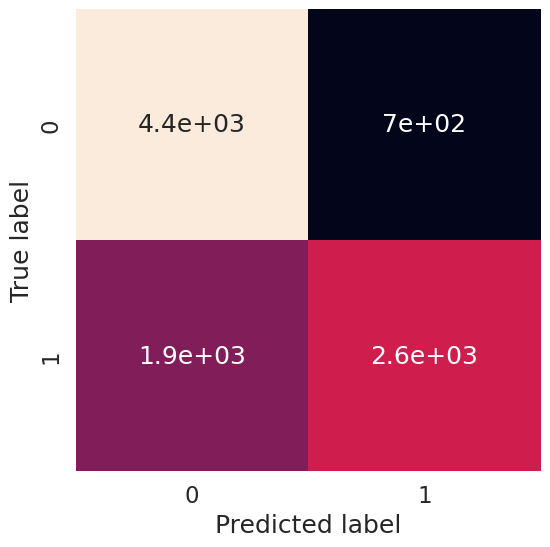

In [45]:
import matplotlib.ticker as ticker
sns.set_theme(font_scale=1.5)

def plot_conf_mat(y_test, y_preds):
    """
    Plots a nice looking confusion matrix using Seaborn's heatmap().
    """
    matrix = confusion_matrix(y_test, y_preds)
    print(matrix)
    
    fig, ax = plt.subplots(figsize=(6, 6))
    ax = sns.heatmap(
        matrix,
        annot=True, # Annotate the boxes
        cbar=False
    )
    plt.xlabel("Predicted label") # predictions go on the x-axis
    plt.ylabel("True label") # true labels go on the y-axis 

y_preds = model.predict(X_test)
plot_conf_mat(y_test, y_preds)

In [46]:
print(
    classification_report(y_test, preds)
)

              precision    recall  f1-score   support

       False       0.70      0.86      0.77      5142
        True       0.79      0.58      0.67      4546

    accuracy                           0.73      9688
   macro avg       0.74      0.72      0.72      9688
weighted avg       0.74      0.73      0.72      9688



['remaining_days' 0.04503916342692493]
['transaction_date_day_of_year' 0.03966962287593723]
['transaction_date_day' 0.03699198895715206]
['membership_expire_date_day_of_year' 0.03554564826309735]
['is_auto_renew' 0.03471721411672915]
['total_secs' 0.0281089958463628]
['membership_expire_date_day' 0.027715458167517065]
['registration_init_time_day_of_year' 0.027303902485202893]
['num_100' 0.02667362647086743]
['num_unq' 0.02666963509947797]
['safra_month' 0.024214047655044486]
['total_secs-2M' 0.02406061179758442]
['membership_expire_date_month' 0.02359572037785111]
['num_25' 0.023438340688144595]
['num_unq-1M' 0.02325966698167034]
['total_secs-1M' 0.023166721374515382]
['num_100-1M' 0.0230124873747446]
['num_100-2M' 0.022922683407957795]
['transaction_date_month' 0.022599224494493017]
['num_unq-2M' 0.02235615317974382]
['transaction_date_day_of_week' 0.022269358523917083]
['registration_init_time_day' 0.02160522367627002]
['payment_method_id_39' 0.021157495893736267]
['num_25-1M' 0.021

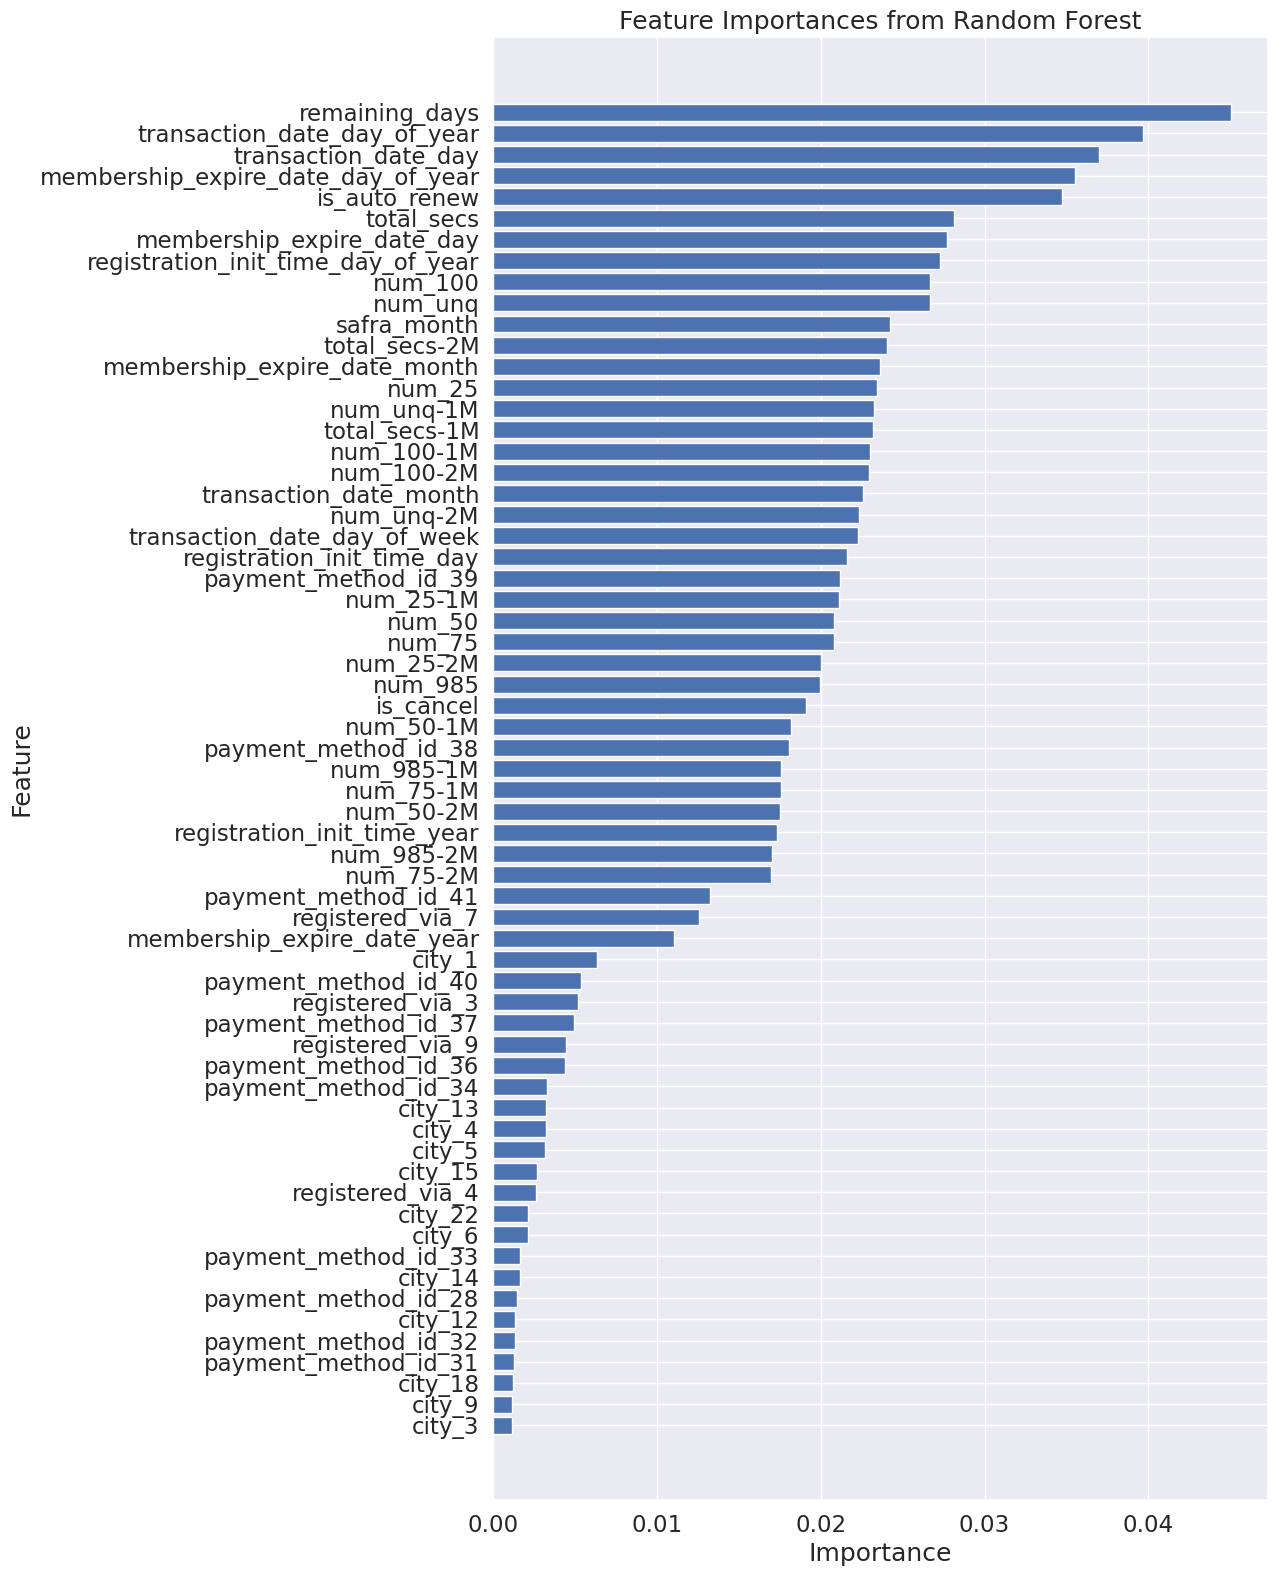

In [47]:
import matplotlib.pyplot as plt

# Get feature importances
importances = model.feature_importances_
feature_names = X.drop('safra', axis=1).columns

# Create a DataFrame for feature importances
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the DataFrame by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# feature_importances = feature_importances[:50]

for f in feature_importances.values:
    print(f)

feature_importances = feature_importances[feature_importances['Importance'] >= 0.001]

# Plot the feature importances
plt.figure(figsize=(10, 19))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Random Forest')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top
plt.show()

In [48]:
import joblib
SAVED_MODEL_FILENAME = './models/random_forest_model_' + datetime.now().strftime('%Y-%m-%d-%Hh-%Mm') + '.joblib'
joblib.dump(model, SAVED_MODEL_FILENAME)

['./models/random_forest_model_2025-04-05-08h-05m.joblib']

In [49]:
loaded_model = joblib.load(SAVED_MODEL_FILENAME)
loaded_model

RandomForestClassifier(bootstrap=False, max_depth=30, max_features='log2',
                       min_samples_split=10, random_state=42)